In [95]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import numpy as np
# import scipy.spatial
import pandas as pd
import sys
# import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.decomposition import PCA
# %matplotlib inline
# Dimension reduction and clustering libraries
# import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
# sys.path.insert(0, '../utils/') 
sys.path.insert(0, '../') 
print(sys.path)
from ads.utils.readProfiles import *
from ads.utils.global_variables import ABRVS
from ads.utils.general import saveAsNewSheetToExistingFile, write_dataframe_to_excel
from ads.models.Classifier import *
from ads.scripts.classify_moa import get_moa_filename
# from readProfiles import *
# from dataset_paper_repo.utils.pred_models import *
# from dataset_paper_repo.utils.readProfiles import *
# from dataset_paper_repo.utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile, write_dataframe_to_excel

# from utils import networksEvol, tsne, readProfiles
# import umap


['../', '../', '../', '/sise/home/alonshp/AnomalyDetectionScreening', '/sise/home/alonshp/AnomalyDetectionScreening/2.MoA_prediction', '/sise/home/alonshp/AnomalyDetectionScreening', '/sise/home/alonshp/AnomalyDetectionScreening/2.MoA_prediction', '../', '/sise/home/alonshp/AnomalyDetectionScreening/2.MoA_prediction', '/sise/home/alonshp/AnomalyDetectionScreening/2.MoA_prediction', '/home/alonshp/AnomalyDetectionScreening/ads', '/home/alonshp/.conda/envs/pytorch_ads/lib/python310.zip', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/lib-dynload', '', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages', '/tmp/tmpter86snq']


## MoA Prediction:
- Data Fusion Methods:
    - Early Fusion: simple concatenation
    - Late Fusion: desision probabilty average
    - RGCCA

### Paths

In [97]:
from datetime import datetime
import os

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
dataset='CDRP-bio'
dataset='LINCS'
modality = 'CellPainting'
################################################

# exp_name = 'not_by_plate_12_09_t'
exp_name = 'report_911_t'

train=False
debug=False
tune = False
compare_ae = True
concat_representaions = True

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected', 'augmented_after_ae'
# profileType='ads_augmented_fs_selected_normalized_ae'
profile_type='augmented'
# profileType='normalized_variable_selected'

################################################
# filtering to compounds which have high replicates for both GE and CP datasets

# 'highRepUnion','highRepOverlap','', 'onlyCP'
filter_perts='highRepUnion'
# filter_perts=''
filter_by_pr = False
rep_corr_fileName='RepCorrDF'
by_dose = False
normalize_by_all=False
filter_groups = ['CP', 'l1k']
folds =10
nSamplesMOA=4

debug=False


profTypeAbbrev=''.join([s[0] for s in profile_type.split('_')])


if compare_ae:
    Types = ['ae','ae_error', 'baseline']
    Types = ['ae_diff', 'baseline']

    profileTypes = [f'{profile_type}_{t}' for t in Types]
    profTypeAbbrev = [ABRVS[p] for p in profileTypes]
    profiles  = {}

    # profiles = {
    #     # '4to1':{'path':f'/storage/users/g-and-n/tabular_models_results/41/ALL/zscores'},
    #     # '2to1':{'path':f'/storage/users/g-and-n/tabular_models_results/21/ALL/zscores'},
    #     'anomaly':{'name':'anomaly','path':os.path.join(output_dir,f'replicate_level_cp_{profileType}_ae.csv')},
    #     'anomaly_err':{'name':'anomaly_err','path':os.path.join(output_dir,f'replicate_level_cp_{profileType}_ae_diff.csv')},
    #     'raw':{'name':'raw','path': os.path.join(output_dir,f'replicate_level_cp_{profileType}_baseline.csv')},
    #     # 'raw_unchanged':{'name':'raw_unchanged','path': os.path.join(data_dir,'CellPainting',f'replicate_level_cp_{profileType}.csv.gz')}
    #     # '5to5':{'path':f'/storage/users/g-and-n/tabular_models_results/55/ALL/zscores'},
    # }

    # profTypeAbbrev = ['AE','Raw']

################################################
# filtering to compounds which have high replicates for both GE and CP datasets

# 'highRepUnion','highRepOverlap','', 'onlyCP'
# filter_perts='highRepUnion'
# filter_perts=''
filter_by_pr = False
rep_corr_fileName='RepCorrDF'


rawProf_dir='/sise/assafzar-group/assafzar/genesAndMorph'
# procProf_dir='./'
base_dir='/sise/assafzar-group/assafzar/genesAndMorph'
res_dir = f'{base_dir}/results/'
datetime_today = datetime.now().strftime('%Y_%m_%d_%H_%M')
# datetime()
# exp_name = datetime_today
# save_dir = f'{res_dir}/MoA_prediction/{exp_name}/'
save_dir = f'{base_dir}/results/{dataset}/{modality}/{exp_name}/MoAprediction/'
os.makedirs(save_dir,exist_ok=True)

data_dir = f'{base_dir}/anomaly_output/{dataset}/CellPainting/{exp_name}' 
# exp_dir = f'{res_dir}/{exp_name}'
# res_dir = f'{procProf_dir}/results'
# procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# s3://imaging-platform/projects/2018_04_20_Rosetta/workspace/preprocessed_data
# aws s3 sync preprocessed_data s3://cellpainting-datasets/Rosetta-GE-CP/preprocessed_data --profile jumpcpuser
profiles = {}
for p in profileTypes:
    profiles[p] = {}
    profiles[p]['cp_path'] = os.path.join(data_dir,f'replicate_level_cp_{p}.csv')
    
# filename='../../results/RepCor/'+fileName+'.xlsx'
# os.makedirs(procProf_dir,exist_ok=True)
os.makedirs(save_dir,exist_ok=True)



### Read GE and CP profiles 

In [98]:


moa_csv_fileName, exp_suffix, filter_abrv = get_moa_filename(profile_type, by_dose, filter_groups, folds, nSamplesMOA, normalize_by_all)
# (configs.data.profile_type, configs.eval.by_dose, configs.moa.filter_groups, configs.moa.folds, configs.moa.min_samples, )
save_dir = os.path.join(save_dir,moa_csv_fileName)



## Train MoA classifier

In [99]:

moa_col='Metadata_MoA'
moa_col_name='Metadata_moa_with_n'


if train:
    # profiles={}
    for p in profileTypes:
        # profiles[p] = {}
        
        mergProf_treatLevel, cp_features,l1k_features = \
        read_paired_treatment_level_profiles(base_dir,dataset,p,filter_repCorr_params,1,exp_name)
        
    ##################################
        if dataset=='LINCS':
            mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
            mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
            mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()    
            mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]
        
        elif dataset=='CDRP-bio':
            mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa'].str.lower()
            mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]

        if filter_by_pr:
            mergProf_treatLevel = mergProf_treatLevel[mergProf_treatLevel['PERT'].isin(profile_type_pr['old_ind'])]
            print('filtered by pr', mergProf_treatLevel.shape[0])
            print('number of features', len(cp_features))
        # mergProf_repLevel,mergProf_treatLevel,l1k_features,cp_features,pertColName=readMergedProfiles(dataset,profileType,nRep)
        # cp_features,l1k_features=cp_features.tolist(),l1k_features.tolist()
        # mergProf_repLevel['Compounds']=mergProf_repLevel['PERT'].str[0:13]

        # if profileLevel=='replicate':
        #     l1k=mergProf_repLevel[[pertColName]+l1k_features]
        #     cp=mergProf_repLevel[[pertColName]+cp_features]
        # elif profileLevel=='treatment':

        l1k=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+l1k_features]
        cp=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+cp_features]
        profiles[p]['l1k']= l1k.copy()
        profiles[p]['cp']= cp.copy()
        
        # profiles[p]['cp']= pd.read_csv(profiles[p]['cp_path'],compression = 'gzip')
        # cp_features = profiles[p]['cp'].columns[profiles[p]['cp'].columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]

        ################## stadanrdize the data (alreay done in the preprocessing step) ##################
        # scaler_ge = preprocessing.StandardScaler()
        # scaler_cp = preprocessing.StandardScaler()

        l1k_scaled=profiles[p]["l1k"].copy()
        # l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k_scaled[l1k_features].values)
        cp_scaled=profiles[p]["cp"].copy()
        # cp_scaled[cp_features] = scaler_cp.fit_transform(cp_scaled[cp_features].values.astype('float64'))

        # cp_scaled[cp_scaled[cp_features]>z_trim]=z_trim
        cp_features = cp_scaled.columns[cp_scaled.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
        if z_trim is not None:
            cp_scaled[cp_features] = np.where(cp_scaled[cp_features]>z_trim,z_trim ,cp_scaled[cp_features])
            cp_scaled[cp_features] = np.where(cp_scaled[cp_features]<-z_trim,-z_trim ,cp_scaled[cp_features])
        # cp_scaled[cp_scaled[cp_features]<-z_trim]=-z_trim 
        if 1:
            cp_scaled[cp_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(cp_scaled[cp_features].values)   
            l1k_scaled[l1k_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(l1k_scaled[l1k_features].values) 

        profiles[p]["l1k_scaled"] = l1k_scaled
        profiles[p]["cp_scaled"] = cp_scaled      

        #################### Remove MoAs with less than 4 compounds in their class

        merged_scaled=pd.concat([profiles[p]["cp_scaled"], profiles[p]["l1k_scaled"]], axis=1)
        merged_scaled = merged_scaled.loc[:,~merged_scaled.columns.duplicated()]    
        merged_scaled['Compounds']=merged_scaled['PERT'].str[0:13]
        profiles[p]["merged_scaled"]=merged_scaled


In [100]:
if train:
    #################### keep MOAs with more than "nSamplesMOA" compounds in their class

    nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Compounds']).sample(1).groupby([moa_col]).size().\
    reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)


    nSamplesforEachMOAclass2=mergProf_treatLevel.groupby([moa_col]).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)

    listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA][moa_col].tolist()
    print('If we filter to MoAs which have more than',nSamplesMOA+1,' compounds in their category, ',\
        len(listOfSelectedMoAs),' out of ',nSamplesforEachMOAclass.shape[0] ,' MoAs remain.')



    multi_label_MoAs=[l for l in listOfSelectedMoAs if '|' in l]
    print('There are ',len(listOfSelectedMoAs),'MoA categories, which out of them ',len(multi_label_MoAs),\
        ' have multi labels and is removed')

    listOfSelectedMoAs=[ele for ele in listOfSelectedMoAs if ele not in multi_label_MoAs]

    # ATTENTION: filtered MoAs is computed using the last profileType!!!!
    filteredMOAs=merged_scaled[merged_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True)

    n_samples = filteredMOAs.groupby(['Metadata_MoA']).size().sort_values(ascending=False)
    filteredMOAs['Metadata_moa_n'] = filteredMOAs['Metadata_MoA'].map(n_samples)
    filteredMOAs[moa_col_name] = filteredMOAs['Metadata_MoA'] + ' (n=' + filteredMOAs['Metadata_moa_n'].astype(str) + ')'

    listOfSelectedMoAs_with_n=filteredMOAs[moa_col_name].unique().tolist()
    le = preprocessing.LabelEncoder()
    le.fit(listOfSelectedMoAs_with_n)



    for p in profileTypes:
        merged_scaled=profiles[p]["merged_scaled"]
        filteredMOAs=merged_scaled[merged_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True)
        filteredMOAs['Metadata_moa_n'] = filteredMOAs['Metadata_MoA'].map(n_samples)
        filteredMOAs[moa_col_name] = filteredMOAs['Metadata_MoA'] + ' (n=' + filteredMOAs['Metadata_moa_n'].astype(str) + ')'

        filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col_name].tolist())

        # nSamplesMOA=0 and union
        print("There are ", filteredMOAs.shape[0],"samples across different doses of ",filteredMOAs['Compounds'].unique().shape[0] ,\
            "compounds", ", for ",filteredMOAs["Metadata_MoA"].unique().shape[0], "MoAs")

        nClasses = filteredMOAs['Compounds'].unique().shape[0]

        n_samples = filteredMOAs.groupby(['Metadata_MoA']).size().sort_values(ascending=False)
        filteredMOAs['Metadata_moa_n'] = filteredMOAs['Metadata_MoA'].map(n_samples)
        filteredMOAs['Metadata_moa_with_n'] = filteredMOAs['Metadata_MoA'] + ' (n=' + filteredMOAs['Metadata_moa_n'].astype(str) + ')'
        filteredMOAs.head()

    # for p in profileTypes:
        ########################################################### Prepare data for evaluation ###########################################################

        profiles[p]["data4eval"] =[[profiles[p]["cp_scaled"][profiles[p]["cp_scaled"][moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),cp_features],\
            [profiles[p]["l1k_scaled"][profiles[p]["l1k_scaled"][moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),l1k_features]]
                # [filteredMOAs,cp_features+l1k_features]]





In [101]:
######### concat AnomalyCP and CP profiles #########
if train:
    if concat_representaions:
        profiles['fusion'] = {}
        meta_feautres = [feat for feat in profiles[profileTypes[0]]['cp_scaled'].columns if 'Metadata' in feat]
        profiles['fusion']['cp_scaled'] = pd.merge(profiles[profileTypes[0]]["cp_scaled"], profiles[profileTypes[1]]["cp_scaled"], on=['PERT','Compounds','Metadata_MoA'], how='inner', suffixes=(f'_{ABRVS[profileTypes[0]][0]}', f'_{ABRVS[profileTypes[1]][0]}'))
        # profiles['fusion']['cp_scaled']['PERT'] = profiles['fusion']['cp_scaled'][f'PERT_{ABRVS[profileTypes[0]][0]}']
        # profiles['fusion']['cp_scaled']['Compounds'] = profiles[profileTypes[0]]['cp_scaled']['Compounds']
        
        fused_features = [feat for feat in profiles['fusion']['cp_scaled'].columns if 'Cells_' in feat or 'Cytoplasm_' in feat or 'Nuclei_' in feat]
        # profiles['fusion']['cp_scaled'] = pd.concat([profiles[p]["cp_scaled"][cp_features] for p in profileTypes], axis=1)
        # cp_meta_feautres = [feat for feat in profiles['fusion']['cp_scaled'].columns if 'Metadata' in feat]
        # profiles['fusion']['cp_scaled'][meta_feautres]= profiles['normalized_variable_selected_baseline']['cp_scaled'][meta_feautres]
        profiles['fusion']['l1k_scaled'] = profiles[profileTypes[0]]["l1k_scaled"].copy()
        # l1k_meta_features = [feat for feat in profiles['fusion']['l1k_scaled'].columns if 'Metadata' in feat]
        # profiles['fusion']['l1k_scaled'][meta_feautres]= profiles['normalized_variable_selected_baseline']['l1k_scaled'][meta_feautres]
        # profiles['fusion']['merged_scaled'] = pd.concat([profiles[p]["merged_scaled"] for p in profileTypes], axis=1)
        profiles['fusion']['data4eval'] = [[profiles['fusion']["cp_scaled"][profiles['fusion']["cp_scaled"][moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),fused_features],\
            [profiles[p]["l1k_scaled"][profiles['fusion']["l1k_scaled"][moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),l1k_features]]
                # [filteredMOAs,cp_features+l1k_features]]
        if 'fusion' not in profileTypes:
            profileTypes.append('fusion')
        profileTypeAbbrev = profileTypes[0].split('_')[1]
        profTypeAbbrev.append(f'fuse_{profileTypeAbbrev}')

In [102]:
if train:
    nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
    listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
    print(len(listOfSelectedMoAs))

In [103]:
if train:
    for p in profileTypes[:-1]:
        a = profiles[p]['cp_scaled'][cp_features][0:2000].to_numpy().flatten()
        sns.histplot(a, bins=100)
        plt.axvline(x=0.5,color='r')
        plt.title(p)
        # plt.xlim(-5,5)
        plt.show()

In [104]:
# filteredMOAs['Metadata_moa_with_n']

In [105]:
if train:
    filteredMOAs.groupby(['Metadata_MoA']).size().sort_values()
    filteredMOAs.groupby(['Metadata_MoA']).size().sort_values(ascending=False).head(20)

### MoA prediction using each dataset and early and late fusion of datasets

#### StratifiedGroupKFold

In [106]:
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,StratifiedGroupKFold
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm
import xgboost as xgb

test_index_gen = []
res= {}
if train:
            # cls_model='lr'#'mlp';#'lr'
        

    if tune:
        parameter_space_MLP = {
            'hidden_layer_sizes': [(100,),(200),(400)],
            'activation': ['tanh', 'relu'],
            'alpha': [0.0001,0.05],
            'learning_rate': ['constant','adaptive'],
        }


        parameter_space_logistic={"C":[1,10,1000]}


        from sklearn.model_selection import GridSearchCV



    # logo = LeaveOneGroupOut()


    for j, p in enumerate(profileTypes):
        for cls_model in ['lr','mlp']:

        # for cls_model in ['lr','mlp','xgboost']:
        # for cls_model in ['xgboost']:
            

            moa_pred_res=pd.DataFrame(index=filteredMOAs.index,columns=['CP','GE','Early Fusion',\
                            # 'RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion',
                            'Late Fusion',
                            'Metadata_moa_num'])


            moa_pred_res['PERT']=filteredMOAs['PERT']
            # moa_pred_res['Metadata_MoA_with_n']=filteredMOAs['Metadata_MoA_with_n']
            moa_pred_res['Compounds']=filteredMOAs['Compounds']

            sgkf = StratifiedGroupKFold(n_splits=folds,shuffle=True,random_state=1)

            leG = preprocessing.LabelEncoder()
            group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

            i=0
            # for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
            for train_index, test_index in tqdm(sgkf.split(filteredMOAs,filteredMOAs['Metadata_moa_num'].values, groups=group_labels)):
            # for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
            # for train_index, test_index in tqdm(sgkf_split):
                print('rand ',i)
                i+=1
                if debug and i == 2:
                        break
                test_index_gen.append(test_index)
            #     data_train = filteredMOAs.loc[train_index,domXfeats].values;
                labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
            #     print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)

            #     data_test = filteredMOAs.loc[test_index,domXfeats].values;
                labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
            #     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    

            #     class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
            #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")

            #     overSampleMinorityFirstClassTo=np.max([labels_train.count(i) for i in set(labels_train)])

            #     ratios = {l: overSampleMinorityFirstClassTo for l in set(labels_train) \
            #       if labels_train.count(l)<overSampleMinorityFirstClassTo}
            #     sm1=RandomOverSampler(ratio=ratios)
                moa_pred_res.loc[test_index,'Fold']=i

                sm1=RandomOverSampler(sampling_strategy='not majority',random_state=5)

                probs=[]

                for n,dt_modality,col in zip([0,1,2,3],profiles[p]["data4eval"],['CP','GE','Early Fusion',
                                                                    #   'RGCCA_CP',\
                            # 'RGCCA_GE','RGCCA_EarlyFusion',
                            'Fold']):
                    print(f'training represntation {p} on modality {col} with model {cls_model} fold {i}')
                    data_m=dt_modality[0]

                    dt_train=data_m.loc[train_index,dt_modality[1]].values;
                    dt_test=data_m.loc[test_index,dt_modality[1]].values; 
                #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
            #         model_tr = GaussianNB()
            #         model_tr = ComplementNB()

            #         model_tr = RandomForestClassifier(n_estimators=10)

                    if cls_model=='lr':
            #             model_tr = LogisticRegression(multi_class='multinomial',class_weight="balanced")        

                        
                        # if tune:
                            # model_logistic = LogisticRegression(multi_class='multinomial',class_weight="balanced",n_jobs=4) 
                            # model_tr = GridSearchCV(model_logistic, parameter_space_logistic, n_jobs=4, cv=3)
                        # else:
                        model_tr = LogisticRegression(multi_class='multinomial',class_weight="balanced", max_iter=500) 

                    elif cls_model=='mlp':
            #             model_MLP = MLPClassifier(random_state=5,max_iter=100,alpha=0.0001,activation='tanh')
                        if tune:
                            model_MLP = MLPClassifier(random_state=5,max_iter=600)
                            model_tr = GridSearchCV(model_MLP, parameter_space_MLP, n_jobs=4, cv=3)
                        else:
                            # model_tr = MLPClassifier(random_state=5,max_iter=200,alpha=0.0001,activation='tanh')
                            model_tr = MLPClassifier(random_state=5,max_iter=600,alpha=0.0001,activation='relu',hidden_layer_sizes=(200,),learning_rate='constant')
                    # elif cls_model=='mlp_torch':
                    elif cls_model=='mlp_pytorch':
                        # trainer.fit(model=model, datamodule=datamodule)
                        model_tr = ElasticNetMLP(in_features = dt_train.shape[1], num_classes = nClasses,epochs=600, hidden_size = 100)
                    elif cls_model=='xgboost':
                        model_tr = xgb.XGBClassifier(n_estimators=500,learning_rate=0.05)
                        # model_tr = xgb.XGBRegressor(tree_method="hist", device="cuda")

                        # model_tr = get_model(dt_train.shape[1], 200, nClasses)
                        # criterion = get_criterion()
                        # optimizer = get_optimizer(model_tr, 0.001)
                        # batch_size = 64
                        # epochs = 100
                        # train_losses = get_train_losses(model_tr, train_loader, criterion, optimizer, epochs)
                        # test_losses = get_test_losses(model_tr, train_loader, criterion, optimizer, epochs)
                        # test_accs = get_test_accs(model_tr, train_loader, criterion, optimizer, epochs)
                        # pred = get_pred(model_tr, test_loader)

                        # accc = accuracy_score(labels_test, pred)
                        # print("Test score: %f" % accc)
                        # moa_pred_res.loc[test_index,col]=pred
                        # moa_pred_res.loc[test_index,'Metadata_moa_num']=labels_test


                    dt_train_balanced,labels_train_balanced = sm1.fit_resample(dt_train,labels_train)

                    model_tr.fit(dt_train_balanced,labels_train_balanced)
                    
                    if  'mlp' in cls_model:
                        print("Training set score: %f" % model_tr.score(dt_train_balanced,labels_train_balanced))
                        
                        # if tune:
                            # print(model_tr.best_params_)
                        # print(model_tr.best_score_)
                    # else:
                    #     print("Training set loss: %f" % model_tr.loss_)
                        
                    accc=model_tr.score(dt_test,labels_test)
                    print("Test score: %f" % accc)
                    # print(model_tr.predict(dt_test))
                    # accc=f1_score(labels_test,model_tr.predict(dt_test), average='weighted')        
                    moa_pred_res.loc[test_index,col]=model_tr.predict(dt_test)
            #         moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
                    probs.append(model_tr.predict_proba(dt_test))


            #     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
                prob_sum = probs[0]
                for pro in range(1,len(probs)):
                    prob_sum+=probs[pro]
                labels_lateFusion=model_tr.classes_[np.argmax(prob_sum/len(probs),axis=1)]
                moa_pred_res.loc[test_index,'Late Fusion']=labels_lateFusion
                moa_pred_res.loc[test_index,'Metadata_moa_num']=labels_test

                del model_tr
                if 'torch' in cls_model:
                    torch.cuda.empty_cache()
                    
            #     f1_score(labels_test,labels_lateFusion, average='weighted')*100
            #     accuracy_score(labels_test,labels_lateFusion)*100

            moa_pred_res['Metadata_moa_num']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)    
            # print(moa_pred_res.mean())
            if tune:
                tuneStr='t'
            
            profile_abrv = profTypeAbbrev[j]
            sheetname = f'{profile_abrv}-{f}-{cls_model}-{folds}f{tuneStr}{z_trim_str}'
            
            if not debug:
                save_path = os.path.join(save_dir,f'{moa_csv_fileName}.xlsx')
                write_dataframe_to_excel(save_path,sheetname,moa_pred_res)
            else:
                res[sheetname] = moa_pred_res
                # saveAsNewSheetToExistingFile(filename,moa_pred_res,'fC-'+dataset+'-'+profTypeAbbrev+'-'+f+'-preds-'+cls_model+'-ht-sgkf-10f')


## Visualize the results

In [107]:
moa_csv_fileName

'augmented_n4_f10_a_cl'

In [108]:

if debug:
    saved_scores_cdrpbio = res
else:
    filename=os.path.join(save_dir,'pred_moa_res_all.xlsx')
    saved_scores_cdrpbio=pd.read_excel(filename, sheet_name=None)
sgkf_keys = saved_scores_cdrpbio.keys()
sgkf_keys


dict_keys(['anomaly_diff-lr', 'anomaly_diff-mlp', 'raw_a-lr', 'raw_a-mlp', 'fuse-lr', 'fuse-mlp'])

In [109]:

# if filter_perts:
#     sgkf_keys = [k for k in sgkf_keys if '-f-' in k]
# else:  
#     sgkf_keys = [k for k in sgkf_keys if '-f-' not in k]

# if filter_by_pr:
#     sgkf_keys = [k for k in sgkf_keys if 'pr' in k]
# else:
#     sgkf_keys = [k for k in sgkf_keys if 'pr' not in k]
# sgkf_keys

# if tune:
#     sgkf_keys = [k for k in sgkf_keys if 'tune' in k]
# else:   
#     sgkf_keys = [k for k in sgkf_keys if 'tune' not in k]

# sgkf_keys

# # sgkf_keys = [k for k in sgkf_keys if '10' not in k]

# if z_trim is not None:
#     sgkf_keys = [k for k in sgkf_keys if z_trim_str in k]
# # sgkf_keys = ['CDRP-bio-AE-filtlr-ht-sgkf-10f', 'CDRP-bio-AE-filtmlp-ht-sgkf-10f', 'CDRP-bio-Raw-filtlr-ht-sgkf-10f', 'CDRP-bio-Raw-filtmlp-ht-sgkf-10f']
# sgkf_keys

for key in saved_scores_cdrpbio.keys():
    print('num values for {key} is {num}'.format(key=key,num=saved_scores_cdrpbio[key].shape[0]))
saved_scores_cdrpbio['raw_a-lr'].shape

num values for anomaly_diff-lr is 1810
num values for anomaly_diff-mlp is 1810
num values for raw_a-lr is 1810
num values for raw_a-mlp is 1810
num values for fuse-lr is 1810
num values for fuse-mlp is 1810


(1810, 10)

In [110]:
saved_scores_cdrpbio[k]['CP']

0        4
1       24
2       16
3       19
4       19
        ..
1805     2
1806    15
1807    18
1808    23
1809    11
Name: CP, Length: 1810, dtype: int64

In [111]:
def compute_f1(df,model_name,data_type,e,f=None):
    # f1 = f1_score(df['Metadata_moa_num'].tolist(),df['Late Fusion'].tolist(), average='weighted')
    modalities= ['CP', 'GE','Late Fusion']
    # output_df = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
    output_df = pd.DataFrame([])

    for dd in modalities:
        scor_vals=df[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
        # print(f'data type: {data_type}, model: {model_name}, modality: {dd}, fold: {f}')
        f1_macro=f1_score(scor_vals,df.Metadata_moa_num.values, average='macro')
        f1_weighted=f1_score(scor_vals,df.Metadata_moa_num.values, average='weighted')

        if f is not None:
            temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': [model_name],'F1-macro':[f1_macro],'F1-weighted':[f1_weighted],'Type':[data_type],'Fold':[f],'exp_num':[e]})
        else:
            temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': [model_name],'F1-macro':[f1_macro],'F1-weighted':[f1_weighted],'Type':[data_type],'exp_num':[e]})
        output_df = pd.concat([output_df,temp_df])
    return output_df

def concat_model_scores(df,model_name='MLP',data_type='AE'):
    # methods= ['CP', 'GE', 'Early Fusion','Late Fusion']
    folds=df['Fold'].unique().tolist()
    exps = df['exp_num'].unique().tolist()
    res_df_exp_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num'])
    res_df_fold_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
    for e in exps:
        df_e = df[df['exp_num']==e]
        temp_df = compute_f1(df_e,model_name,data_type,e)
        res_df_exp_level=pd.concat([res_df_exp_level,temp_df])
        # res_df_by_exp
        for f in folds:
            df_f=df_e[df_e['Fold']==f]
            temp_df = compute_f1(df_f,model_name,data_type,e,f)
            res_df_fold_level=pd.concat([res_df_fold_level,temp_df])
                    #    ,'RGCCA_EarlyFusion']:
                
                # res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
                
    return res_df_fold_level, res_df_exp_level       


In [112]:
saved_scores_cdrpbio.keys()
# saved_scores_cdrpbio[sgkf_keys[0]]
# sgkf_keys
# methods.keys()

dict_keys(['anomaly_diff-lr', 'anomaly_diff-mlp', 'raw_a-lr', 'raw_a-mlp', 'fuse-lr', 'fuse-mlp'])

In [113]:
# saved_scores_cdrpbio[sgkf_keys[2]].head()
# reps[0]
saved_scores_cdrpbio[k].keys()

Index(['CP', 'GE', 'Early Fusion', 'Late Fusion', 'Metadata_moa_num', 'PERT',
       'Metadata_moa_with_n', 'Compounds', 'Fold', 'exp_num'],
      dtype='object')

In [255]:
from sklearn.metrics import f1_score
#########################################################
res_df =pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
res_df_exp_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','Fold','exp_num'])

# DS='CDRP-bio'
# scores_mlp=saved_scores_cdrpbio[DS+'-nvs-mlp-ht-sgkf-10f']
# scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-mlp-ht']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filtmlp-ht-5']
# scores_mlp['mofa']=mofa_scores_2add['mofa']
reps = ['CellProfiler', 'Anomaly', 'Fusion']
methods = ['lr', 'mlp']

# res_df = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
for i ,k in enumerate(sgkf_keys):
    # data_representation = k.split('-')[0]
    # m = methods[i]
    if 'anomaly' in k:
        data_representation = reps[1]
    elif 'raw' in k: 
        data_representation = reps[0]
    else:
        data_representation= reps[2]

    if 'mlp' in k:
        model = 'MLP'
    elif 'lr' in k: 
        model = 'Logistic R'
    elif 'xgboost' in k:
        model = 'XGBoost'
    print(model)
    print(data_representation)
    res_df_method, res_df_exp_level_method = concat_model_scores(saved_scores_cdrpbio[k], model,data_type = data_representation) 
    res_df = pd.concat([res_df,res_df_method])
    res_df_exp_level = pd.concat([res_df_exp_level,res_df_exp_level_method])
    
n_classes = saved_scores_cdrpbio[k].Metadata_moa_num.nunique()


Logistic R
Anomaly
MLP
Anomaly
Logistic R
CellProfiler
MLP
CellProfiler
Logistic R
Fusion
MLP
Fusion


In [256]:
profTypeAbbrev# n_classes = saved_scores_cdrpbio[k].Metadata_moa_num.nunique()
# res_df.Type.value_counts()
# k.split('-')[0]
res_df.head()
# res_df.isna().sum()

,Modality,Model,Type,F1-macro,F1-weighted,exp_num,Fold
0,CP,Logistic R,Anomaly,0.382900,0.494312,4,1
0,GE,Logistic R,Anomaly,0.447090,0.579012,4,1
0,Late Fusion,Logistic R,Anomaly,0.486848,0.674868,4,1
0,CP,Logistic R,Anomaly,0.634524,0.654762,4,3
0,GE,Logistic R,Anomaly,0.469565,0.594444,4,3


In [257]:
saved_scores_cdrpbio[k].head()

,CP,GE,Early Fusion,Late Fusion,Metadata_moa_num,PERT,Metadata_moa_with_n,Compounds,Fold,exp_num
0,24,4,NaN,4,4,BRD-A03506276,HSP inhibitor (n=6),BRD-A03506276,1,4
1,24,24,NaN,24,24,BRD-A05821830,tubulin polymerization inhibitor (n=7),BRD-A05821830,3,4
2,16,16,NaN,16,16,BRD-A11319535,glucocorticoid receptor agonist (n=15),BRD-A11319535,1,4
3,19,14,NaN,19,11,BRD-A11990600,benzodiazepine receptor agonist (n=5),BRD-A11990600,5,4
4,19,9,NaN,19,22,BRD-A12896037,serotonin receptor agonist (n=6),BRD-A12896037,2,4


In [258]:
# saved_scores_cdrpbio[k].groupby('PERT')[['CP','GE','Late Fut']].mean().head()

In [259]:
res_df["Modality"].value_counts()
# res_df.head()

Modality
CP             300
GE             300
Late Fusion    300
Name: count, dtype: int64

In [260]:
res_df.head(100)

,Modality,Model,Type,F1-macro,F1-weighted,exp_num,Fold
0,CP,Logistic R,Anomaly,0.382900,0.494312,4,1
0,GE,Logistic R,Anomaly,0.447090,0.579012,4,1
0,Late Fusion,Logistic R,Anomaly,0.486848,0.674868,4,1
0,CP,Logistic R,Anomaly,0.634524,0.654762,4,3
0,GE,Logistic R,Anomaly,0.469565,0.594444,4,3
...,...,...,...,...,...,...,...
0,Late Fusion,Logistic R,Anomaly,0.380556,0.516204,3,3
0,CP,Logistic R,Anomaly,0.508772,0.579630,3,5
0,GE,Logistic R,Anomaly,0.404762,0.486111,3,5
0,Late Fusion,Logistic R,Anomaly,0.481667,0.581481,3,5


/tmp/ipykernel_8867/1378920297.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


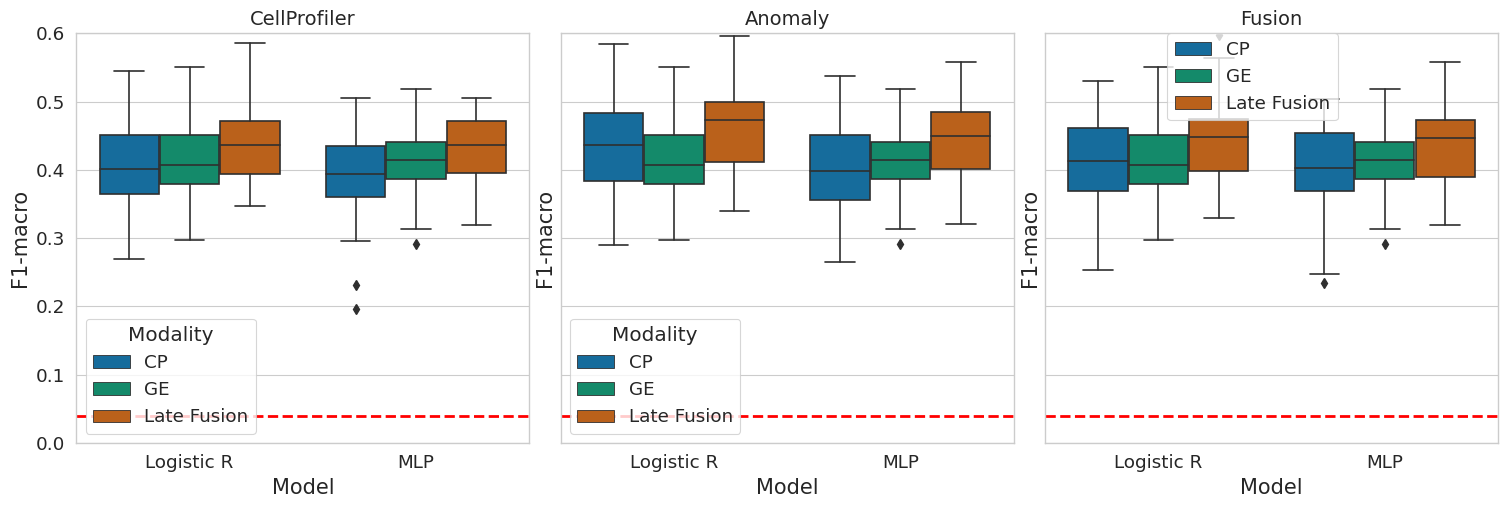

In [261]:
# res_df_cdrpbio
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# sns.set_style("whitegrid")
n_cols = len(reps)
fig,axes=plt.subplots(1,n_cols,figsize=(5*n_cols,5),sharey=True)
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(reps):
    # p_abrv = p.split('_')[0]
    # print(p_abrv)
    sns.boxplot(x="Model", y="F1-macro", hue="Modality", data=res_df[res_df["Type"]==p],ax=axes[i])#,**kwargs)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,0.6)
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
# axes[0].legend([],[], frameon=False)
plt.tight_layout()

/tmp/ipykernel_8867/2197750860.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


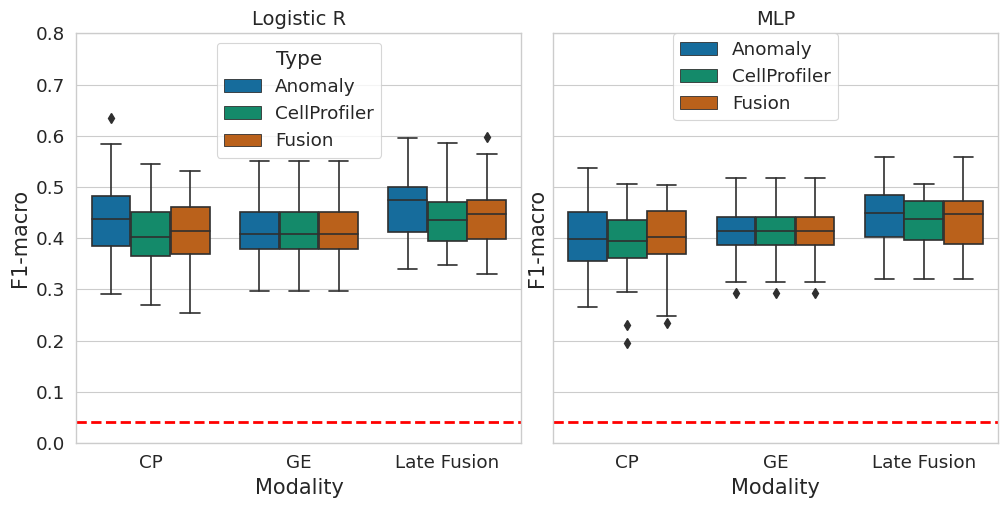

In [262]:
# res_df_cdrpbio
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# sns.set_style("whitegrid")
methods = ['AnomalyCP','CP']
models = ['Logistic R','MLP','XGBoost']
models = ['Logistic R','MLP']

Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']
nCols = len(models)
fig,axes=plt.subplots(1,nCols,figsize=(5*nCols,5),sharey=True)

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(models):
    sns.boxplot(x="Modality", y="F1-macro", hue="Type", data=res_df[res_df["Model"]==p],ax=axes[i])#,**kwargs)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,0.8)
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
# axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(save_dir,f'moa_all_modalities_bar_{profile_type}.png')
plt.savefig(save_path,dpi=500)

/tmp/ipykernel_8867/1589332278.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


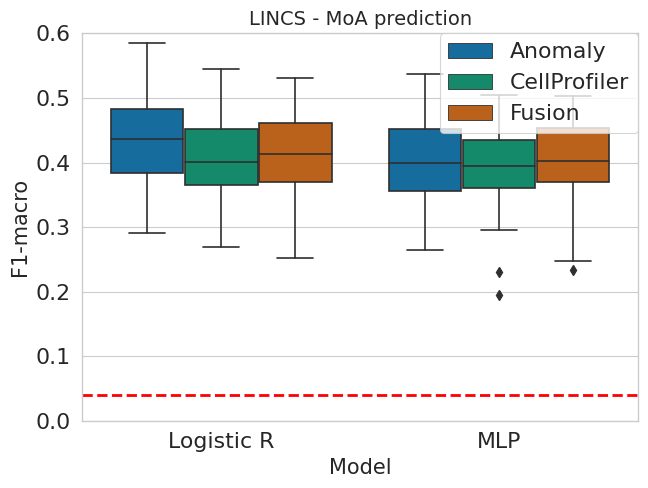

In [263]:
# res_df_cdrpbio
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.8, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# sns.set_style("whitegrid")
# fig,axes=plt.subplots(1,1,figsize=(5,5),sharey=True)
methods = ['AnomalyCP','CP']
models = ['Logistic R','MLP']
Modalities = ['CP', 'GE', 'Early Fusion']
modality = 'CP'
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
# for i,p in enumerate(models):
hue_order = ['CellProfiler', 'Anomaly', 'Fusion']
g = sns.boxplot(x="Model", y="F1-macro", hue="Type", data=res_df[res_df["Modality"]==modality],hue_order=hue_orders)#,**kwargs)
    # plt.legend(loc='top', borderaxespad=0)

g.set_ylim(0,0.6)
# axes[0].set_title('CDRP-bio')
g.set_title(f'{dataset} - MoA prediction')
# n_classes=16;
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
# g.legend(bbox_to_anchor=(0.27, 1), loc='upper right', borderaxespad=0)
g.legend( loc='upper right', borderaxespad=0)

# axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(save_dir,f'moa_{modality}_bar_{profile_type}.png')
plt.savefig(save_path,dpi=500)

In [264]:
# test_index_gen
# fused_features
# profiles['fusion']['cp_scaled'].head()
# classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err.values,output_dict=True)
# saved_scores_cdrpbio['anomaly_err_nvs-f-lr-5f'].isna().sum()
# scores_mlp
# scor_vals_ae_err
# saved_scores_cdrpbio['raw_nvs-f-lr-5f'].isna().sum()
# saved_scores_cdrpbio['anomaly_err_nvs-f-lr-5f'].isna().sum()
# saved_scores_cdrpbio['raw_nvs-f-lr-5f'].drop_duplicates().head()

# res_df[60:120]
# res_df_grouped_folds = res_df.groupby(['Model','Modality','Type','exp_num']).mean().reset_index().sort_values(by=['F1-macro'],ascending=False)
res_df_grouped_folds = res_df.groupby(['Model','Modality','Type','exp_num']).mean().reset_index()

/tmp/ipykernel_8867/1884212615.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


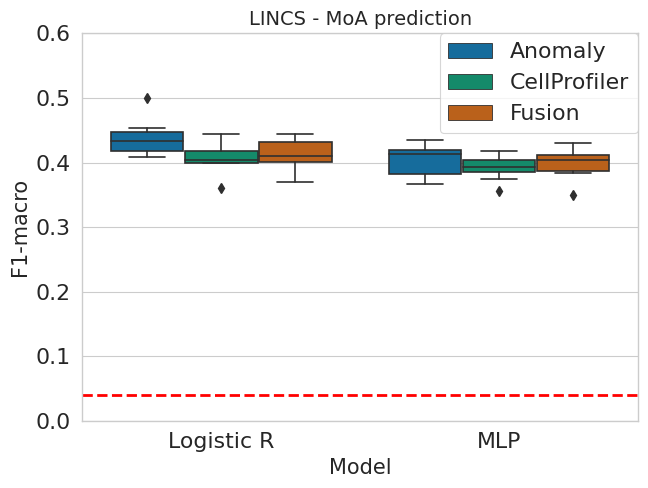

In [265]:
# res_df_cdrpbio
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.8, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# sns.set_style("whitegrid")
# fig,axes=plt.subplots(1,1,figsize=(5,5),sharey=True)
methods = ['AnomalyCP','CP']
models = ['Logistic R','MLP']
Modalities = ['CP', 'GE', 'Early Fusion']
modality = 'CP'
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
# for i,p in enumerate(models):
g = sns.boxplot(x="Model", y="F1-macro", hue="Type", data=res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality])#,**kwargs)
    # plt.legend(loc='top', borderaxespad=0)

g.set_ylim(0,0.6)
# axes[0].set_title('CDRP-bio')
g.set_title(f'{dataset} - MoA prediction')
# n_classes=16;
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
# g.legend(bbox_to_anchor=(0.27, 1), loc='upper right', borderaxespad=0)
g.legend( loc='upper right', borderaxespad=0)

# axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(save_dir,f'moa_{modality}_bar_{profile_type}.png')
plt.savefig(save_path,dpi=500)

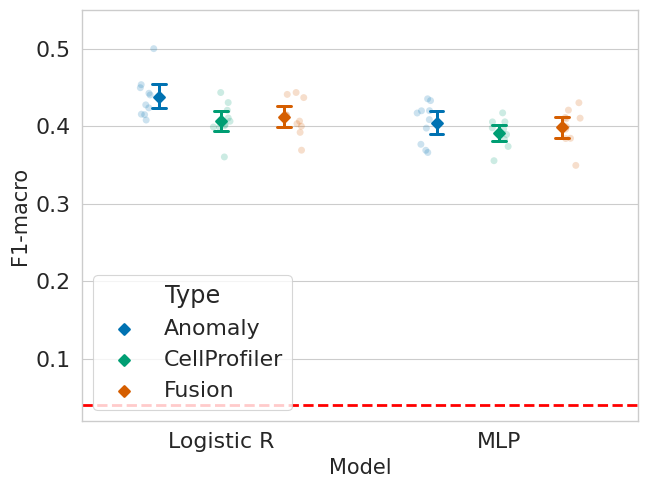

In [266]:
# res_df_grouped_folds.groupby(['Model','Modality','Type'])['F1-macro'].describe()
# res_df_grouped_folds

sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-macro", hue="Type",
    dodge=True, alpha=.2, legend=False,
)
g =sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-macro", hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D"
    # markerssize=20, markersedgewidth=3,
)
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
g.set_ylim(0.02,0.55)
plt.tight_layout()

(0.3, 0.6)

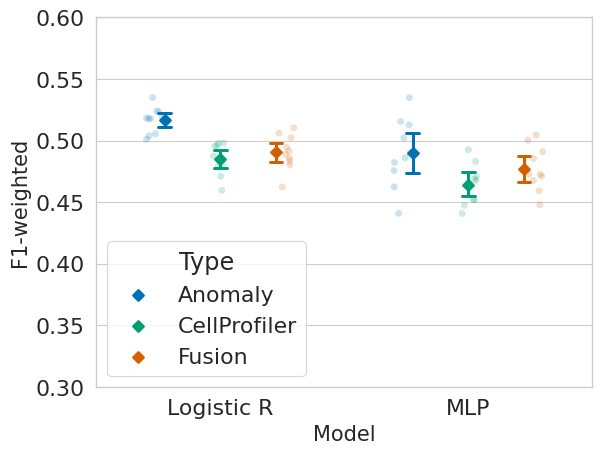

In [267]:
# res_df_grouped_folds.groupby(['Model','Modality','Type'])['F1-macro'].describe()
res_df_grouped_folds

sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-weighted", hue="Type",
    dodge=True, alpha=.2, legend=False,
)
g =sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-weighted", hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D"
    # markerssize=20, markersedgewidth=3,
)
# g = sns.barplot(
#     data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-weighted", hue="Type",
#     errorbar=("pi", 50), capsize=.1,
#     # err_kws={"color": ".5", "linewidth": 2.5},
#     # linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0),
# )
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
g.set_ylim(0.3,0.6)

['anomaly_diff-mlp', 'raw_a-mlp', 'fuse-mlp']
Index(['AE_err', 'Raw', 'Fusion', 'Metadata_moa_num', 'Metadata_moa_with_n'], dtype='object')


/tmp/ipykernel_8867/3628246441.py:78: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


['anomaly_diff-lr', 'raw_a-lr', 'fuse-lr']
Index(['AE_err', 'Raw', 'Fusion', 'Metadata_moa_num', 'Metadata_moa_with_n'], dtype='object')


/tmp/ipykernel_8867/3628246441.py:78: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


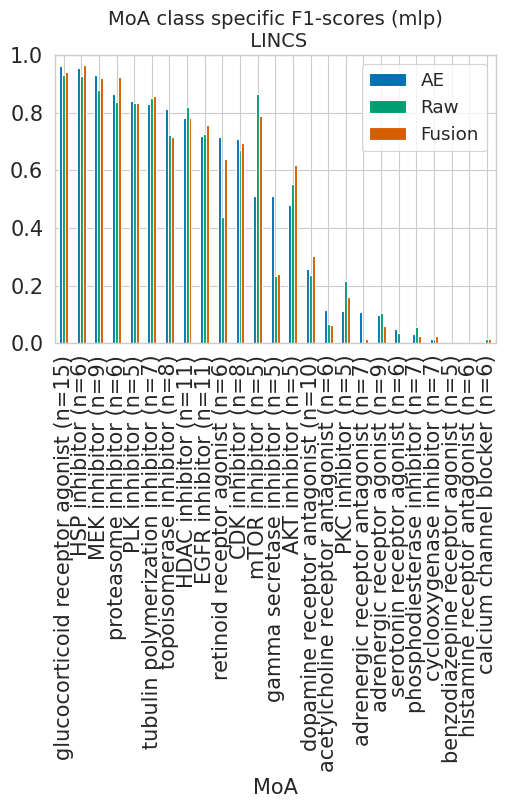

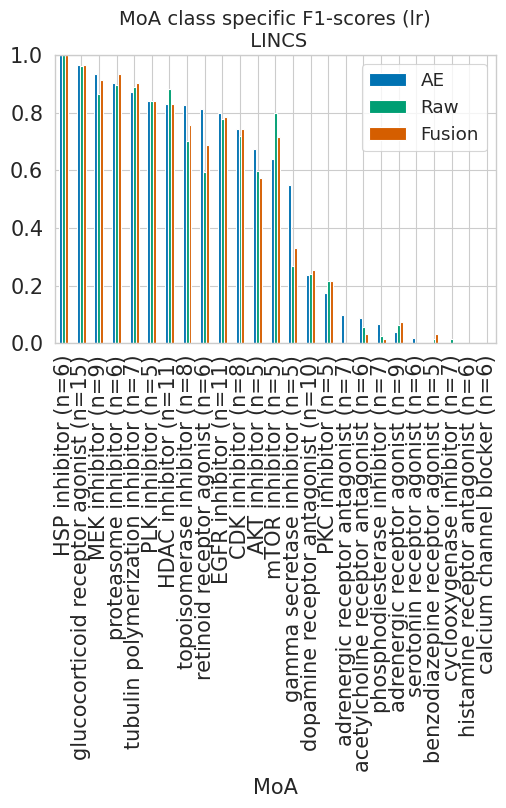

In [268]:

from sklearn.metrics import classification_report

# for model in ['lr','mlp','xgb']:
for model in ['mlp','lr']:


    # model = 'mlp'
    # # 1. Choose results by model and modality
    model_keys = [k for k in sgkf_keys if model in k]
    print(model_keys)

    scores = {}
    scores_mlp={}
    for k in model_keys:
        # if 'err' in k:
            # rep = 'AE_err'
        if 'anomaly' in k:
            rep = 'AE_err'
        elif 'raw' in k:
            rep = 'Raw'
        elif 'fuse' in k:
            rep = 'Fusion'
        
        scores_model = saved_scores_cdrpbio[k]
        scores[rep] = scores_model['CP']

    for rep in scores.keys():
        scores_mlp[rep]  = scores[rep]
        
    scores_mlp['Metadata_moa_num']=scores_model['Metadata_moa_num']
    scores_mlp['Metadata_moa_with_n']=scores_model['Metadata_moa_with_n']
    scores_mlp = pd.DataFrame(scores_mlp)
    print(scores_mlp.keys())
    # # 2. reformat scores to be able to use classification report


    # scores_mlp = pd.concat(saved_scores_cdrpbio[mlp_keys])
    # scores_mlp=res_df[(res_df["Modality"]=="CP") & (res_df["Model"]=="MLP")]
    # scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

    # scor_vals_ae=scores_mlp['AE_pred'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_ae_err=scores_mlp['AE_err'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_raw=scores_mlp['Raw'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_fuse=scores_mlp['Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
 

    # report_clss_ae_pred=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae.values,output_dict=True)).transpose()
    report_clss_ae_err=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err.values,output_dict=True)).transpose()
    report_clss_raw=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw.values,output_dict=True)).transpose()
    report_clss_fuse=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_fuse.values,output_dict=True)).transpose()
    # report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

    
    # report_clss[list(range(13))]
    # n_classes=14
    # n_classes=16

    report_clss_ae_err['MoA']=''
    # report_clss2 
    # report_clss
    # labels = [str(i) for i in range(n_classes)]
    # report_clss_ae_err.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
    mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
    mapping = {k[1]:k[0] for k in mapping}  
    for row in report_clss_ae_err.index[0:n_classes]:
        report_clss_ae_err.loc[row,'MoA']=mapping[int(row)]
    
    report_clss2=report_clss_ae_err[0:n_classes]
    report_clss2



    # # 3. Plotting

    # report_clss_cp.loc[report_clss3.index]['f1-score']
    %matplotlib inline
    import matplotlib.style as style
    style.use('seaborn-colorblind')
    sns.set_style("whitegrid")
    sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
    report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
    report_clss3['f1-score-raw']=report_clss_raw.loc[report_clss3.index]['f1-score'].values
    report_clss3['f1-score-fuse']=report_clss_fuse.loc[report_clss3.index]['f1-score'].values
    # report_clss3['f1-score-ae_err']=report_clss_ae_err.loc[report_clss3.index]['f1-score'].values

    # report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
    # report_clss4=report_clss3[['f1-score','f1-score-raw','f1-score-ae_err']]
    report_clss4=report_clss3[['f1-score','f1-score-raw','f1-score-fuse']]

    report_clss4=report_clss4.rename(columns={'f1-score':'AE','f1-score-raw':'Raw','f1-score-fuse':'Fusion'})
    report_clss4.index=report_clss3['MoA']
    ax = report_clss4.plot.bar(rot=90,figsize=(5,8),fontsize=15)
    # ax = report_clss4[report_clss4["AE"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)

    plt.title(f'MoA class specific F1-scores ({model})\n {dataset}')
    ax.set_ylim([0,1])
    plt.tight_layout()
    save_path = os.path.join(save_dir,f'moa_specific_f1_scores_{dataset}_{model}_{profile_type}.png')
    plt.savefig(save_path,dpi=500)
    # if 1:
    #     source_data_add='../Figs_Source_Data.xlsx'
    #     saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

    #     # fig.tight_layout()
    #     plt.savefig('fig4c_1.pdf',dpi=500)

In [269]:
report_clss_ae_err

,precision,recall,f1-score,support,MoA
0,0.648148,0.700000,0.673077,50.000000,AKT inhibitor (n=5)
1,0.763158,0.725000,0.743590,80.000000,CDK inhibitor (n=8)
2,0.787611,0.809091,0.798206,110.000000,EGFR inhibitor (n=11)
3,0.855769,0.809091,0.831776,110.000000,HDAC inhibitor (n=11)
4,1.000000,1.000000,1.000000,60.000000,HSP inhibitor (n=6)
5,0.897959,0.977778,0.936170,90.000000,MEK inhibitor (n=9)
6,0.233333,0.140000,0.175000,50.000000,PKC inhibitor (n=5)
7,0.888889,0.800000,0.842105,50.000000,PLK inhibitor (n=5)
8,0.058201,0.183333,0.088353,60.000000,acetylcholine receptor antagonist (n=6)
9,0.049180,0.033333,0.039735,90.000000,adrenergic receptor agonist (n=9)


In [270]:
report_clss_raw

,precision,recall,f1-score,support
0,0.617021,0.580000,0.597938,50.000000
1,0.716049,0.725000,0.720497,80.000000
2,0.805825,0.754545,0.779343,110.000000
3,0.947917,0.827273,0.883495,110.000000
4,1.000000,1.000000,1.000000,60.000000
5,0.835052,0.900000,0.866310,90.000000
6,0.232558,0.200000,0.215054,50.000000
7,0.888889,0.800000,0.842105,50.000000
8,0.040984,0.083333,0.054945,60.000000
9,0.072464,0.055556,0.062893,90.000000


In [271]:
res_df.head()

,Modality,Model,Type,F1-macro,F1-weighted,exp_num,Fold
0,CP,Logistic R,Anomaly,0.382900,0.494312,4,1
0,GE,Logistic R,Anomaly,0.447090,0.579012,4,1
0,Late Fusion,Logistic R,Anomaly,0.486848,0.674868,4,1
0,CP,Logistic R,Anomaly,0.634524,0.654762,4,3
0,GE,Logistic R,Anomaly,0.469565,0.594444,4,3


In [272]:
for row in report_clss_ae_err.index[0:n_classes]:
        print(row)
        report_clss_ae_err.loc[int(row),'MoA']=mapping[int(row)]
    
# report_clss_ae_err.loc[0,'MoA']=mapping[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [273]:
mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
mapping = {k[1]:k[0] for k in mapping}
report_clss_ae_err['MoA'] = mapping[report_clss_ae_err.index]
report_clss_ae_err
# set(combinations(scores_mlp[['Metadata_moa_with_n', 'Metadata_moa_num']].itertuples(index=False, name=None), 2))

TypeError: unhashable type: 'Index'

In [ ]:
scores_mlp

,AE_err,Raw,Fusion,Metadata_moa_num,Metadata_moa_with_n
0,0,0,0,13,sodium channel blocker (n=31)
1,2,6,2,4,adrenergic receptor antagonist (n=75)
2,0,11,7,4,adrenergic receptor antagonist (n=75)
3,0,5,0,4,adrenergic receptor antagonist (n=75)
4,0,0,0,4,adrenergic receptor antagonist (n=75)
...,...,...,...,...,...
8055,14,14,14,14,topoisomerase inhibitor (n=53)
8056,14,14,14,14,topoisomerase inhibitor (n=53)
8057,10,10,5,8,dopamine receptor antagonist (n=52)
8058,6,10,5,8,dopamine receptor antagonist (n=52)


In [ ]:
lincs_moa_top=['mTOR inhibitor', 'glucocorticoid receptor agonist', 'HSP inhibitor',
       'proteasome inhibitor', 'MEK inhibitor', 'HDAC inhibitor',
       'tubulin polymerization inhibitor', 'PLK inhibitor', 'EGFR inhibitor',
       'retinoid receptor agonist', 'CDK inhibitor', 'topoisomerase inhibitor',
       'p38 MAPK inhibitor', 'AKT inhibitor', 'serotonin receptor antagonist',
       'gamma secretase inhibitor', 'HMGCR inhibitor', 'PI3K inhibitor',
       'rho associated kinase inhibitor', 'cyclooxygenase inhibitor',
       'protein synthesis inhibitor', 'histamine receptor antagonist',
       'sterol demethylase inhibitor', 'PKC inhibitor',
       'dopamine receptor antagonist', 'adrenergic receptor antagonist',
       'vitamin D receptor agonist', 'acetylcholine receptor antagonist',
       'progesterone receptor agonist', 'dopamine receptor agonist',
       'benzodiazepine receptor agonist', 'phosphodiesterase inhibitor',
       'calcium channel blocker', 'adrenergic receptor agonist']

cdrp_moa_top=['tubulin polymerization inhibitor', 'atpase inhibitor',
       'glucocorticoid receptor agonist', 'cdk inhibitor',
       'adrenergic receptor agonist', 'dopamine receptor antagonist',
       'protein synthesis inhibitor', 'serotonin receptor antagonist',
       'calcium channel blocker', 'dopamine receptor agonist',
       'serotonin receptor agonist', 'adrenergic receptor antagonist']

# top_cdrp_lincs_overlap=list(set(lincs_moa_top) & set(cdrp_moa_top))
top_cdrp_lincs_overlap=['glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'dopamine receptor agonist',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

# ax = report_clss4[:15].plot.bar(rot=90,figsize=(7,7))
ax =report_clss4.loc[top_cdrp_lincs_overlap].plot.bar(rot=90,figsize=(6,6))
ax.set_ylim([0,1])
plt.title('MoA class specific F1-scores')
plt.tight_layout()

KeyError: "None of [Index(['glucocorticoid receptor agonist', 'tubulin polymerization inhibitor',\n       'dopamine receptor antagonist', 'protein synthesis inhibitor',\n       'dopamine receptor agonist', 'serotonin receptor antagonist',\n       'adrenergic receptor antagonist', 'adrenergic receptor agonist',\n       'calcium channel blocker'],\n      dtype='object', name='MoA')] are in the [index]"

In [ ]:
# report_clss4.loc[top_cdrp_lincs_overlap]
top_cdrp_lincs_overlap

['glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'dopamine receptor agonist',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

In [ ]:
report_clss2['support']=report_clss2['support'].astype(int)
report_clss2['n_samples']=report_clss2['support']

/tmp/ipykernel_32398/4073461586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['support']=report_clss2['support'].astype(int)
/tmp/ipykernel_32398/4073461586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['n_samples']=report_clss2['support']


In [ ]:

# plt.figure(figsize=(5,5))
# import matplotlib.style as style
# style.use('seaborn-colorblind')
# sns.scatterplot(data=report_clss2, x="n_samples", y="f1-score", hue="MoA",legend=True)
# plt.tight_layout()# p
# plt.savefig('moa_class_scatter.eps')

In [ ]:
from sklearn.metrics import classification_report
# scores_mlp=saved_scores['fC-CDRP-bio-nvs-filt-preds-mlp-ht']
scores_mlp=saved_scores_cdrpbio['CDRP-bio-nvs-filtmlp-ht-5']
# scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filt-preds-mlp-ht-sgkf-1']
scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=16
report_clss['MoA']=''
# report_clss
labels = [str(i) for i in range(n_classes)]
report_clss.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))

# report_clss.loc[0:n_classes,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Late Fusion of CP and GE'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4.plot.bar(rot=90,figsize=(8,6))
plt.title('MoA class specific F1-scores')
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

KeyError: 'CDRP-bio-nvs-filtmlp-ht-5'

In [ ]:
profiles[profileTypes[0]]['cp'].head()

,PERT,Compounds,Metadata_MoA,Nuclei_Granularity_7_DNA,Cells_AreaShape_Zernike_5_3,Cells_Texture_SumAverage_RNA_10_0,Nuclei_Texture_InfoMeas1_AGP_10_0,Nuclei_RadialDistribution_RadialCV_DNA_2of4,Nuclei_AreaShape_Zernike_7_1,Cells_RadialDistribution_MeanFrac_DNA_1of4,...,Cells_Granularity_7_AGP,Cells_RadialDistribution_MeanFrac_DNA_4of4,Nuclei_AreaShape_Zernike_3_1,Nuclei_Texture_SumAverage_RNA_10_0,Nuclei_Intensity_IntegratedIntensity_DNA,Nuclei_AreaShape_Zernike_2_0,Nuclei_Correlation_K_AGP_DNA,Cells_Correlation_Overlap_DNA_ER,Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4,Cells_Intensity_StdIntensityEdge_Mito
0,BRD-A04231641-003-01-3_10.0,BRD-A04231641,NaN,-0.264622,0.807081,-0.386414,0.081742,-0.273633,-2.066935,0.605935,...,1.065557,0.131064,-1.780924,0.405090,1.625192,1.789100,0.040616,0.067822,1.247974,1.025713
1,BRD-A04438777-001-01-4_10.0,BRD-A04438777,dopamine receptor agonist,0.329668,0.703280,-0.077705,0.813642,-1.068426,-1.876976,-0.087118,...,0.516663,1.185075,-1.414009,0.065854,-0.096426,2.465919,0.269154,0.652037,0.366176,-1.379910
2,BRD-A06352508-001-02-9_10.0,BRD-A06352508,chk inhibitor,0.401566,0.924250,-1.012552,0.640234,-0.719023,-2.989688,-1.269140,...,2.081157,1.921284,-1.346027,-0.159600,-0.254842,3.531163,0.207268,1.578023,1.173281,-0.395136
3,BRD-A07952294-001-02-3_8.93,BRD-A07952294,farnesyltransferase inhibitors,-0.041800,0.965873,-0.288522,0.117821,-0.460816,-0.497151,0.055651,...,0.207931,0.731051,-0.619767,-0.131630,-0.318810,1.110389,0.108630,0.420290,-0.579276,-1.318331
4,BRD-A15914070-001-01-5_10.0,BRD-A15914070,cytotoxic lipid peroxidation product,0.349513,0.409721,-0.370522,0.721858,-0.603690,-2.321964,0.571849,...,1.334717,0.508390,-1.898190,0.381566,0.723224,2.703150,0.607234,0.616687,1.212654,-0.990831


In [ ]:
profiles[profileTypes[1]]['cp'].head()

,PERT,Compounds,Metadata_MoA,Nuclei_Granularity_7_DNA,Cells_AreaShape_Zernike_5_3,Cells_Texture_SumAverage_RNA_10_0,Nuclei_Texture_InfoMeas1_AGP_10_0,Nuclei_RadialDistribution_RadialCV_DNA_2of4,Nuclei_AreaShape_Zernike_7_1,Cells_RadialDistribution_MeanFrac_DNA_1of4,...,Cells_Granularity_7_AGP,Cells_RadialDistribution_MeanFrac_DNA_4of4,Nuclei_AreaShape_Zernike_3_1,Nuclei_Texture_SumAverage_RNA_10_0,Nuclei_Intensity_IntegratedIntensity_DNA,Nuclei_AreaShape_Zernike_2_0,Nuclei_Correlation_K_AGP_DNA,Cells_Correlation_Overlap_DNA_ER,Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4,Cells_Intensity_StdIntensityEdge_Mito
0,BRD-A04231641-003-01-3_10.0,BRD-A04231641,NaN,-0.799937,0.114691,-0.517638,0.028612,-0.931846,0.764567,1.750010,...,-1.606169,-1.959599,0.072195,1.085400,1.849980,-0.233558,1.564405,0.178441,-0.926234,-0.710648
1,BRD-A04438777-001-01-4_10.0,BRD-A04438777,dopamine receptor agonist,0.418703,0.278070,0.127559,-0.365288,-0.566421,0.510057,-0.523591,...,0.357398,-0.364599,0.350724,0.171595,-0.508193,-0.193964,0.567399,0.139890,-0.116119,-0.413985
2,BRD-A06352508-001-02-9_10.0,BRD-A06352508,chk inhibitor,-0.048316,-0.956267,-3.264594,-0.279963,-0.752487,-1.795259,-2.167885,...,0.210484,1.739892,-3.448300,-2.076596,0.937424,1.926309,1.915977,-1.318658,0.730327,-4.498349
3,BRD-A07952294-001-02-3_8.93,BRD-A07952294,farnesyltransferase inhibitors,-0.046405,0.272033,0.127239,0.094547,-0.407864,0.007637,-0.043617,...,0.237888,0.679389,-2.533574,-0.018369,-0.253812,-0.340848,-0.210730,0.840703,0.263274,0.051612
4,BRD-A15914070-001-01-5_10.0,BRD-A15914070,cytotoxic lipid peroxidation product,0.050980,-0.689335,0.082826,0.461509,-1.094516,0.731555,0.968479,...,0.195945,-1.925705,0.792649,0.476247,1.721735,-0.509423,0.371926,0.635822,-1.512223,0.049279


In [ ]:

# report_clss
from sklearn.metrics import classification_report
scores_mlp=saved_scores_cdrpbio['CDRP-bio-Raw-filtmlp-ht-sgkf-10f']
scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=16
report_clss['MoA']=''
# report_clss
labels = [str(i) for i in range(n_classes)]
report_clss.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

# report_clss_cp.loc[report_clss3.index]['f1-score']
%matplotlib inline
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_style("whitegrid")
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Early Fusion'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4[report_clss4["Early Fusion"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)
plt.title('MoA class specific F1-scores\n CDRP-bio')
ax.set_ylim([0,1])
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

# if 1:
#     source_data_add='../Figs_Source_Data.xlsx'
#     saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

#     # fig.tight_layout()
#     plt.savefig('fig4c_1.pdf',dpi=500)

KeyError: 'CDRP-bio-Raw-filtmlp-ht-sgkf-10f'